# Importing the libraries

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import rawpy
import cv2

root = "exercise_2_data/"

def build_channel_masks(array, green_first = True, one_value = False):
    Y_channel_mask = np.zeros_like(array)
    C1_channel_mask = np.zeros_like(array)
    C2_channel_mask = np.zeros_like(array)
    
    if green_first:
        Y_channel_mask[::2, 0::2] = array[::2, 0::2]
        Y_channel_mask[1::2, 1::2] = array[1::2, 1::2]
        C1_channel_mask[::2, 1::2] = array[::2, 1::2]
        C2_channel_mask[1::2, 0::2] = array[1::2, 0::2]
    else:
        Y_channel_mask[0::2, 1::2] = array[0::2, 1::2]
        Y_channel_mask[1::2, 0::2] = array[1::2, 0::2]
        C1_channel_mask[1::2, 1::2] = array[1::2, 1::2]
        C2_channel_mask[0::2, 0::2] = array[0::2, 0::2]

    if one_value:
        Y_channel_mask[0::2, 1::2] = 1
        Y_channel_mask[1::2, 0::2] = 1
        C1_channel_mask[1::2, 1::2] = 1
        C2_channel_mask[0::2, 0::2] = 1
    return Y_channel_mask, C1_channel_mask, C2_channel_mask

# Part 1

Loaded array of size (4014, 6020)
The pens, from top to bottom, are red, green and blue


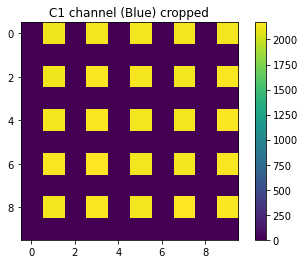

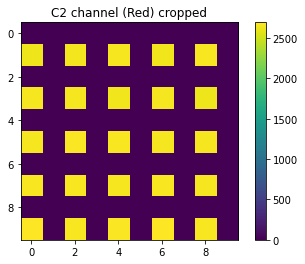

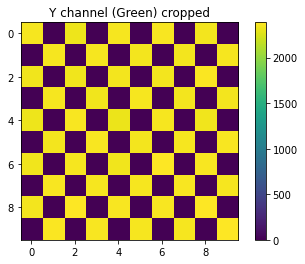

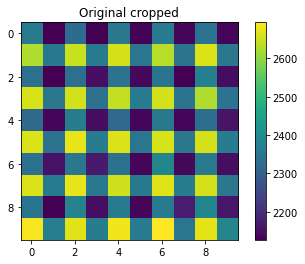

In [12]:
def show_image(image, title):
    plt.imshow(image)
    plt.title(title)
    plt.colorbar()
    plt.show()

array_1 = np.load(f'{root}01/IMG_9939.npy')
print('Loaded array of size', array_1.shape)
print('The pens, from top to bottom, are red, green and blue')

y_1, c1_1, c2_1 = build_channel_masks(array_1, green_first = True)
cropped_red_C1 = c1_1[1440:1450, 2100:2110]
cropped_red_C2 = c2_1[1440:1450, 2100:2110]
cropped_red_Y = y_1[1440:1450, 2100:2110]

cropped_red = array_1[1440:1450, 2100:2110]

show_image(cropped_red_C1, 'C1 channel (Blue) cropped')
show_image(cropped_red_C2, 'C2 channel (Red) cropped')
show_image(cropped_red_Y, 'Y channel (Green) cropped')
show_image(cropped_red, 'Original cropped')

# Part 2

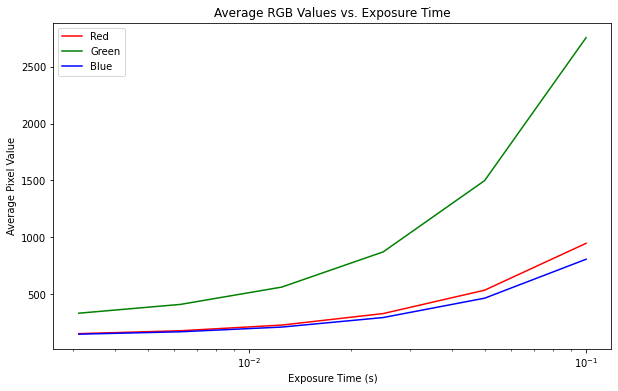

In [15]:
dataset_2 = ["02/IMG_3044.CR3", "02/IMG_3045.CR3", "02/IMG_3046.CR3", "02/IMG_3047.CR3", "02/IMG_3048.CR3", "02/IMG_3049.CR3"]
exposure_times = np.array([1/10, 1/20, 1/40, 1/80, 1/160, 1/320])

avg_red = []
avg_green = []
avg_blue = []

for i in range(len(dataset_2)):
    raw = rawpy.imread(root + dataset_2[i])
    array_2 = np.array(raw.raw_image_visible)
    y_2, c1_2, c2_2 = build_channel_masks(array_2, green_first = False)
    avg_red.append(np.mean(c2_2))
    avg_green.append(np.mean(y_2))
    avg_blue.append(np.mean(c1_2))

plt.figure(figsize=(10, 6))
plt.plot(exposure_times, avg_red, 'r-', label='Red')
plt.plot(exposure_times, avg_green, 'g-', label='Green')
plt.plot(exposure_times, avg_blue, 'b-', label='Blue')
plt.xlabel('Exposure Time (s)')
plt.ylabel('Average Pixel Value')
plt.title('Average RGB Values vs. Exposure Time')
plt.legend()
plt.xscale('log')  # Since exposure times decrease exponentially
plt.show()

# Part 3

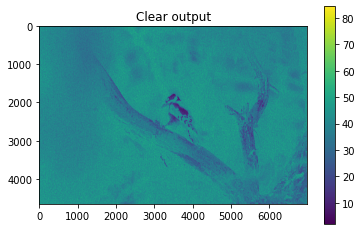

In [24]:
raw = rawpy.imread(f"{root}03/IMG_4782.CR3")
array_3 = np.array(raw.raw_image_visible)

y_3, c1_3, c2_3 = build_channel_masks(array, green_first = False)

def demosaic_channel(X, M):
    MX = M * X
    numerator = convolve2d(MX, K, mode='same', boundary='symm')
    denominator = convolve2d(M, K, mode='same', boundary='symm')
    with np.errstate(divide='ignore', invalid='ignore'):
        C = numerator / denominator
        C[denominator == 0] = 0  # Safeguard for division by zero
    return C

K = np.ones((3, 3))
# Demosaic each channel
y_demosaiced = demosaic_channel(array_3, y_3)
c1_demosaiced = demosaic_channel(array_3, c1_3)
c2_demosaiced = demosaic_channel(array_3, c2_3)

clear_output = y_demosaiced + c1_demosaiced + c2_demosaiced

height, width = clear_output.shape
bayer_image = clear_output.reshape((height, width)).astype(np.uint8)

# Convert Bayer image to RGB
rgb_image = cv2.cvtColor(bayer_image, cv2.COLOR_BAYER_BG2RGB)

cv2.imwrite("output.png", rgb_image)
show_image(clear_output, 'Clear output')